In [1]:
import re
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import string
import nltk
import seaborn as sns
import io
!pip install -U -q PyDrive
  
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Importing fake news data

In [2]:
#importing fake news data
link = 'https://drive.google.com/file/d/1BdDAqSxMm2qzNaNkfO6bOAyPDqzrQbZJ/view?usp=sharing'
  
import pandas as pd
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Fake.csv')  
  
data_fake = pd.read_csv('Fake.csv')
data_fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


Importing true news data

In [3]:
link = 'https://drive.google.com/file/d/1irFnB2bI1C_B3SwH4d8tFFNo1Y7yUSon/view?usp=sharing'
  
import pandas as pd
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('True.csv')  
  
data_true = pd.read_csv('True.csv')
data_true

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


Labelling fake and true data and combining them to a single data frame. Shuffling the ordered data and choosing a short segment of it because of computational limits of free google colab.

In [4]:
data_fake['target'] = 'fake'
data_true['target'] = 'true'
news_data = pd.concat([data_fake, data_true]).reset_index(drop = True)
news_data = shuffle(news_data)
news_data = news_data.reset_index(drop=True)
news_data
#Reducing rows to reduce load
news_data=news_data.iloc[32000:40000,:]
news_data

,title,text,subject,date,target
32000,BREAKING: TWO RUSSIAN NAVY SPY SHIPS OPERATING...,Attacks against us are increasing in frequenc...,Government News,"Apr 7, 2015",fake
32001,Drug enforcement chief criticizes Trump in ema...,WASHINGTON (Reuters) - The U.S. Drug Enforceme...,politicsNews,"August 1, 2017",true
32002,House Intelligence postpones closed session wi...,WASHINGTON (Reuters) - The U.S. House of Repre...,politicsNews,"March 27, 2017",true
32003,Tillerson says would support maintaining Russi...,WASHINGTON (Reuters) - President-elect Donald ...,politicsNews,"January 11, 2017",true
32004,BOOM! This Is How President Reagan Handled Pro...,Ronald Reagan shut down the Berkeley protests ...,Government News,"Nov 11, 2016",fake
...,...,...,...,...,...
39995,POWERFUL: A RAPE SURVIVOR EXPLAINS Why Men Sho...,This is a powerful story of a courageous young...,left-news,"Apr 21, 2016",fake
39996,BRILLIANT! TUCKER CARLSON and AYAAN HIRSI ALI ...,,politics,"Mar 22, 2017",fake
39997,Just When Hillary Thought The News About Her C...,How this woman is even trending in the polls s...,politics,"Oct 3, 2015",fake
39998,Maine’s Horrible Governor Just Outright Decla...,"Paul LePage, who might as well be Maine s vers...",News,"August 26, 2016",fake


Checking for any missing entries in the data

In [5]:
print("Number of missing elements from title\t:", news_data[news_data['title'].isna()].shape[0])
print("Number of missing elements from text\t:", news_data[news_data['text'].isna()].shape[0])
print("Number of missing elements from subject\t:", news_data[news_data['subject'].isna()].shape[0])
print("Number of missing elements from date\t:", news_data[news_data['date'].isna()].shape[0])
print("Number of missing elements from target\t:", news_data[news_data['target'].isna()].shape[0])

Number of missing elements from title	: 0
Number of missing elements from text	: 0
Number of missing elements from subject	: 0
Number of missing elements from date	: 0
Number of missing elements from target	: 0


As there are no missing entries we move forward. Now removing date column as it isn't a good feature for classification. Combining the text, title, subject colums data into a single row for reducing features.

In [6]:
news_data.drop(["date"],axis=1,inplace=True)
news_data['title_text_subject'] = news_data['title'] + news_data['text'] + news_data['subject']
news_data.head()


,title,text,subject,target,title_text_subject
32000,BREAKING: TWO RUSSIAN NAVY SPY SHIPS OPERATING...,Attacks against us are increasing in frequenc...,Government News,fake,BREAKING: TWO RUSSIAN NAVY SPY SHIPS OPERATING...
32001,Drug enforcement chief criticizes Trump in ema...,WASHINGTON (Reuters) - The U.S. Drug Enforceme...,politicsNews,true,Drug enforcement chief criticizes Trump in ema...
32002,House Intelligence postpones closed session wi...,WASHINGTON (Reuters) - The U.S. House of Repre...,politicsNews,true,House Intelligence postpones closed session wi...
32003,Tillerson says would support maintaining Russi...,WASHINGTON (Reuters) - President-elect Donald ...,politicsNews,true,Tillerson says would support maintaining Russi...
32004,BOOM! This Is How President Reagan Handled Pro...,Ronald Reagan shut down the Berkeley protests ...,Government News,fake,BOOM! This Is How President Reagan Handled Pro...


Counting of the No. of fake and true cases in our combined set

In [7]:
number_of_fake_arcs = news_data.loc[news_data['target'] == 'fake'].count()[0]
number_of_true_arcs = news_data.loc[news_data['target'] == 'true'].count()[0]
print("Number of fake samples",number_of_fake_arcs)
print("Number of true samples",number_of_true_arcs)

Number of fake samples 4214
Number of true samples 3786


**Data Pre-processing**

Making the data lowercase

In [8]:
news_data['title_text_subject'] = news_data['title_text_subject'].apply(lambda x: x.lower())
news_data['title_text_subject']

32000    breaking: two russian navy spy ships operating...
32001    drug enforcement chief criticizes trump in ema...
32002    house intelligence postpones closed session wi...
32003    tillerson says would support maintaining russi...
32004    boom! this is how president reagan handled pro...
                               ...                        
39995    powerful: a rape survivor explains why men sho...
39996    brilliant! tucker carlson and ayaan hirsi ali ...
39997    just when hillary thought the news about her c...
39998     maine’s horrible governor just outright decla...
39999    trump promises to work with nato to defeat isl...
Name: title_text_subject, Length: 8000, dtype: object

Removing stopwords from the data

In [9]:
nltk.download('stopwords')
from nltk.corpus import stopwords
wordstop = stopwords.words('english')
news_data['title_text_subject'] = news_data['title_text_subject'].apply(lambda x: ' '.join([word for word in x.split() if word not in (wordstop)]))
news_data['title_text_subject']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


32000    breaking: two russian navy spy ships operating...
32001    drug enforcement chief criticizes trump email ...
32002    house intelligence postpones closed session fb...
32003    tillerson says would support maintaining russi...
32004    boom! president reagan handled protesters: “ne...
                               ...                        
39995    powerful: rape survivor explains men never all...
39996    brilliant! tucker carlson ayaan hirsi ali disc...
39997    hillary thought news couldn’t get worse…this b...
39998    maine’s horrible governor outright declared bl...
39999    trump promises work nato defeat islamic statey...
Name: title_text_subject, Length: 8000, dtype: object

Converting data available as words into numbers using CountVectorizer 

In [10]:
prof_vector = CountVectorizer()
A = prof_vector.fit_transform(news_data['title_text_subject'].values)
A = A.toarray()
A.shape

(8000, 62784)

**Naive Bayes classifier**

Splitting the data into 20% training and 80% test sets

In [11]:
Y = news_data['target'].values
A_train, A_test, Y_train, Y_test = train_test_split(A, Y, shuffle=True, test_size=0.2, random_state=2)

Training the Multinomial Naïve Bayes classifier on training data

In [12]:
SADclassif = MultinomialNB(alpha=2)
SADclassif.fit(A_train, Y_train)

MultinomialNB(alpha=2, class_prior=None, fit_prior=True)

Calculating the accuracy score of the classifier

In [13]:
print(SADclassif.score(A_train, Y_train))
print(SADclassif.score(A_test, Y_test))

0.974375
0.9575


Evaluating the model using confusion matrix ploted using heatmap

---



In [14]:
prediction_results = SADclassif.predict(A_test)
confused = confusion_matrix(Y_test, prediction_results)

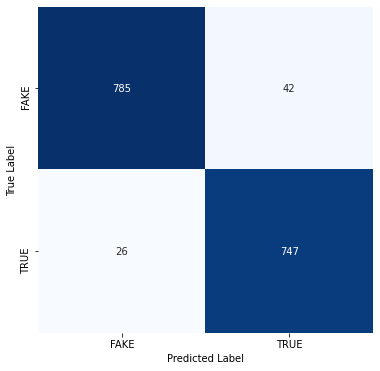

In [16]:
plt.figure(figsize=(6,6))
sns.heatmap(confused, annot=True, fmt='d', xticklabels=['FAKE', 'TRUE'], yticklabels=['FAKE', 'TRUE'], cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()